In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Bagian 1 - Data Preprocessing

class DataPreprocessor:
    
    def __init__(self, data_path):
        self.data_path = data_path
        self.data = None
        self.processed_data = None
    
    def load_data(self):
        """Memuat data dari file CSV"""
        self.data = pd.read_excel(self.data_path, engine="openpyxl")
        print("Data berhasil dimuat!")
        print(f"Shape data: {self.data.shape}")
        return self.data
    
    def explore_data(self):
        """Eksplorasi data untuk memahami struktur dan distribusi"""
        print("\n=== EKSPLORASI DATA ===")
        print("\nInfo Dataset:")
        print(self.data.info())
        
        print("\nSample Data:")
        print(self.data.head())
        
        print("\nDistribusi Target (Depression):")
        print(self.data['Depression'].value_counts())
        
        self._plot_feature_distributions()
    
    def _plot_feature_distributions(self):
        """Membuat visualisasi distribusi fitur"""
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle('Distribusi Fitur Dataset Depression', fontsize=16)
        
        self.data['Sleep Duration'].value_counts().plot(kind='bar', ax=axes[0,0])
        axes[0,0].set_title('Sleep Duration')
        axes[0,0].tick_params(axis='x', rotation=45)
        
        self.data['Dietary Habits'].value_counts().plot(kind='bar', ax=axes[0,1])
        axes[0,1].set_title('Dietary Habits')
        
        axes[0,2].hist(self.data['Academic Pressure'].dropna(), bins=10, edgecolor='black')
        axes[0,2].set_title('Academic Pressure')
        
        axes[1,0].hist(self.data['Study Hours'].dropna(), bins=10, edgecolor='black')
        axes[1,0].set_title('Study Hours')
        
        axes[1,1].hist(self.data['Financial Stress'].dropna(), bins=10, edgecolor='black')
        axes[1,1].set_title('Financial Stress')
        
        self.data['Depression'].value_counts().plot(kind='bar', ax=axes[1,2])
        axes[1,2].set_title('Depression (Target)')
        
        plt.tight_layout()
        plt.show()
    
    def preprocess_data(self):
        """
        Preprocessing data:
        1. Konversi variabel kategorik ke numerik
        2. Normalisasi data
        3. Pembentukan fitur gabungan
        """
        print("\n=== PREPROCESSING DATA ===")
        
        processed = self.data.copy()
        
        sleep_mapping = {
            'Less than 5 hours': 1,
            '5-6 hours': 2,
            '7-8 hours': 3,
            'More than 8 hours': 4
        }
        processed['Sleep_Numeric'] = processed['Sleep Duration'].map(sleep_mapping)
        
        diet_mapping = {
            'Unhealthy': 1,
            'Moderate': 2,
            'Healthy': 3
        }
        processed['Diet_Numeric'] = processed['Dietary Habits'].map(diet_mapping)
        
        processed['Suicidal_Numeric'] = processed['Have you ever had suicidal thoughts ?'].map({'No': 0, 'Yes': 1})
        
        processed['Family_History_Numeric'] = processed['Family History of Mental Illness'].map({'No': 0, 'Yes': 1})
        
        processed['Depression_Numeric'] = processed['Depression'].map({'No': 0, 'Yes': 1})
        
        
        processed['Lifestyle_Score'] = (
            processed['Sleep_Numeric'] * 0.4 +
            processed['Diet_Numeric'] * 0.4 +
            (1 - processed['Suicidal_Numeric']) * 0.2  # Inversi karena suicidal thoughts negatif
        )
        
        study_hours_normalized = (processed['Study Hours'] - processed['Study Hours'].min()) / (processed['Study Hours'].max() - processed['Study Hours'].min()) * 4 + 1
        processed['Academic_Stress_Score'] = (
            processed['Academic Pressure'] * 0.6 +
            study_hours_normalized * 0.4
        )
        
        processed['Depression_Predisposition'] = (
            processed['Financial Stress'] * 0.7 +
            processed['Family_History_Numeric'] * 1.5  # Family history memiliki bobot lebih tinggi
        )
        
        self.processed_data = processed
        
        print("\nStatistik Fitur Gabungan:")
        feature_cols = ['Lifestyle_Score', 'Academic_Stress_Score', 'Depression_Predisposition']
        print(processed[feature_cols].describe())
        
        return processed

In [ ]:
# Bagian 2 - Definisi Membership Fuzzy

class FuzzyMembershipFunctions:
    @staticmethod
    def trimf(x, a, b, c):
        left = 0 if b == a else (x - a) / (b - a)
        right = 0 if c == b else (c - x) / (c - b)
        return np.maximum(0, np.minimum(left, right))

    @staticmethod
    def trapmf(x, a, b, c, d):
        """Fungsi keanggotaan trapezoidal"""
        return np.maximum(0, np.minimum(np.minimum((x - a) / (b - a), 1), (d - x) / (d - c)))

    @staticmethod
    def gaussmf(x, mean, sigma):
        """Fungsi keanggotaan Gaussian"""
        return np.exp(-0.5 * ((x - mean) / sigma) ** 2)


In [ ]:
# Bagian 3 - Fuzzy Inference System (Mamdani)

class MamdaniFIS:
    def __init__(self):
        self.membership_functions = {}
        self.rules = []
        self.setup_membership_functions()
        self.setup_rules()
    
    def setup_membership_functions(self):
        self.membership_functions['lifestyle'] = {
            'poor': lambda x: FuzzyMembershipFunctions.trimf(x, 1, 1, 2.5),
            'moderate': lambda x: FuzzyMembershipFunctions.trimf(x, 1.5, 2.5, 3.5),
            'good': lambda x: FuzzyMembershipFunctions.trimf(x, 2.5, 4, 4)
        }
        
        self.membership_functions['academic'] = {
            'low': lambda x: FuzzyMembershipFunctions.trimf(x, 1, 1, 3),
            'medium': lambda x: FuzzyMembershipFunctions.trimf(x, 2, 3, 4),
            'high': lambda x: FuzzyMembershipFunctions.trimf(x, 3, 5, 5)
        }
        
        self.membership_functions['predisposition'] = {
            'low': lambda x: FuzzyMembershipFunctions.trimf(x, 0, 0, 3),
            'medium': lambda x: FuzzyMembershipFunctions.trimf(x, 1, 3, 5),
            'high': lambda x: FuzzyMembershipFunctions.trimf(x, 3, 6, 6)
        }
        
        self.membership_functions['depression_risk'] = {
            'low': lambda x: FuzzyMembershipFunctions.trimf(x, 0, 0, 0.5),
            'medium': lambda x: FuzzyMembershipFunctions.trimf(x, 0.2, 0.5, 0.8),
            'high': lambda x: FuzzyMembershipFunctions.trimf(x, 0.5, 1, 1)
        }
    
    def setup_rules(self):
        self.rules = [
            (('good', 'low', 'low'), 'low'),
            (('good', 'low', 'medium'), 'low'),
            (('good', 'medium', 'low'), 'low'),
            (('moderate', 'low', 'low'), 'low'),
            
            (('good', 'high', 'low'), 'medium'),
            (('good', 'medium', 'medium'), 'medium'),
            (('good', 'low', 'high'), 'medium'),
            (('moderate', 'medium', 'low'), 'medium'),
            (('moderate', 'low', 'medium'), 'medium'),
            (('moderate', 'high', 'low'), 'medium'),
            (('poor', 'low', 'low'), 'medium'),
            
            (('good', 'high', 'medium'), 'high'),
            (('good', 'high', 'high'), 'high'),
            (('good', 'medium', 'high'), 'high'),
            (('moderate', 'high', 'medium'), 'high'),
            (('moderate', 'medium', 'high'), 'high'),
            (('moderate', 'high', 'high'), 'high'),
            (('poor', 'medium', 'low'), 'high'),
            (('poor', 'low', 'medium'), 'high'),
            (('poor', 'high', 'low'), 'high'),
            (('poor', 'medium', 'medium'), 'high'),
            (('poor', 'low', 'high'), 'high'),
            (('poor', 'medium', 'high'), 'high'),
            (('poor', 'high', 'medium'), 'high'),
            (('poor', 'high', 'high'), 'high')
        ]
    
    def fuzzify(self, lifestyle, academic, predisposition):
        fuzzified = {}
        
        fuzzified['lifestyle'] = {
            'poor': self.membership_functions['lifestyle']['poor'](lifestyle),
            'moderate': self.membership_functions['lifestyle']['moderate'](lifestyle),
            'good': self.membership_functions['lifestyle']['good'](lifestyle)
        }
        
        fuzzified['academic'] = {
            'low': self.membership_functions['academic']['low'](academic),
            'medium': self.membership_functions['academic']['medium'](academic),
            'high': self.membership_functions['academic']['high'](academic)
        }
        
        fuzzified['predisposition'] = {
            'low': self.membership_functions['predisposition']['low'](predisposition),
            'medium': self.membership_functions['predisposition']['medium'](predisposition),
            'high': self.membership_functions['predisposition']['high'](predisposition)
        }
        
        return fuzzified
    
    def apply_rules(self, fuzzified_inputs):
        rule_outputs = {'low': [], 'medium': [], 'high': []}
        
        for rule_antecedent, rule_consequent in self.rules:
            lifestyle_term, academic_term, predisposition_term = rule_antecedent
            
            strength = min(
                fuzzified_inputs['lifestyle'][lifestyle_term],
                fuzzified_inputs['academic'][academic_term],
                fuzzified_inputs['predisposition'][predisposition_term]
            )
            
            if strength > 0:
                rule_outputs[rule_consequent].append(strength)
        
        aggregated_output = {}
        for output_class in ['low', 'medium', 'high']:
            if rule_outputs[output_class]:
                aggregated_output[output_class] = max(rule_outputs[output_class])
            else:
                aggregated_output[output_class] = 0
        
        return aggregated_output
    
    def defuzzify(self, aggregated_output):
        output_range = np.arange(0, 1.01, 0.01)
        
        membership_degrees = np.zeros_like(output_range)
        
        for i, output_val in enumerate(output_range):
            low_membership = min(aggregated_output['low'], 
                               self.membership_functions['depression_risk']['low'](output_val))
            medium_membership = min(aggregated_output['medium'], 
                                  self.membership_functions['depression_risk']['medium'](output_val))
            high_membership = min(aggregated_output['high'], 
                                self.membership_functions['depression_risk']['high'](output_val))
            
            membership_degrees[i] = max(low_membership, medium_membership, high_membership)
        
        if np.sum(membership_degrees) == 0:
            return 0.5  # Default jika tidak ada membership
        
        centroid = np.sum(output_range * membership_degrees) / np.sum(membership_degrees)
        return centroid
    
    def predict(self, lifestyle, academic, predisposition):
        """Prediksi menggunakan sistem fuzzy Mamdani"""
        fuzzified = self.fuzzify(lifestyle, academic, predisposition)
        
        aggregated = self.apply_rules(fuzzified)
        
        output = self.defuzzify(aggregated)
        
        return output

In [ ]:
# Bagian 4 - Fuzzy Inference System (Sugeno)

class SugenoFIS:
    
    def __init__(self):
        self.membership_functions = {}
        self.rules = []
        self.setup_membership_functions()
        self.setup_rules()
    
    def setup_membership_functions(self):
        self.membership_functions['lifestyle'] = {
            'poor': lambda x: FuzzyMembershipFunctions.trimf(x, 1, 1, 2.5),
            'moderate': lambda x: FuzzyMembershipFunctions.trimf(x, 1.5, 2.5, 3.5),
            'good': lambda x: FuzzyMembershipFunctions.trimf(x, 2.5, 4, 4)
        }
        
        self.membership_functions['academic'] = {
            'low': lambda x: FuzzyMembershipFunctions.trimf(x, 1, 1, 3),
            'medium': lambda x: FuzzyMembershipFunctions.trimf(x, 2, 3, 4),
            'high': lambda x: FuzzyMembershipFunctions.trimf(x, 3, 5, 5)
        }
        
        self.membership_functions['predisposition'] = {
            'low': lambda x: FuzzyMembershipFunctions.trimf(x, 0, 0, 3),
            'medium': lambda x: FuzzyMembershipFunctions.trimf(x, 1, 3, 5),
            'high': lambda x: FuzzyMembershipFunctions.trimf(x, 3, 6, 6)
        }
    
    def setup_rules(self):
        
        self.rules = [
            (('good', 'low', 'low'), (-0.1, 0.05, 0.05, 0.2)),
            (('good', 'low', 'medium'), (-0.05, 0.05, 0.1, 0.25)),
            (('good', 'medium', 'low'), (-0.05, 0.1, 0.05, 0.3)),
            (('moderate', 'low', 'low'), (0, 0.05, 0.05, 0.3)),
            
            (('good', 'high', 'low'), (-0.05, 0.15, 0.05, 0.4)),
            (('good', 'medium', 'medium'), (-0.05, 0.1, 0.1, 0.45)),
            (('good', 'low', 'high'), (-0.05, 0.05, 0.15, 0.5)),
            (('moderate', 'medium', 'low'), (0, 0.1, 0.05, 0.45)),
            (('moderate', 'low', 'medium'), (0, 0.05, 0.1, 0.45)),
            (('moderate', 'high', 'low'), (0, 0.15, 0.05, 0.5)),
            (('poor', 'low', 'low'), (0.1, 0.05, 0.05, 0.5)),
            
            (('good', 'high', 'medium'), (-0.05, 0.15, 0.1, 0.65)),
            (('good', 'high', 'high'), (-0.05, 0.15, 0.15, 0.7)),
            (('good', 'medium', 'high'), (-0.05, 0.1, 0.15, 0.7)),
            (('moderate', 'high', 'medium'), (0, 0.15, 0.1, 0.7)),
            (('moderate', 'medium', 'high'), (0, 0.1, 0.15, 0.7)),
            (('moderate', 'high', 'high'), (0, 0.15, 0.15, 0.75)),
            (('poor', 'medium', 'low'), (0.1, 0.1, 0.05, 0.7)),
            (('poor', 'low', 'medium'), (0.1, 0.05, 0.1, 0.7)),
            (('poor', 'high', 'low'), (0.1, 0.15, 0.05, 0.75)),
            (('poor', 'medium', 'medium'), (0.1, 0.1, 0.1, 0.75)),
            (('poor', 'low', 'high'), (0.1, 0.05, 0.15, 0.8)),
            (('poor', 'medium', 'high'), (0.1, 0.1, 0.15, 0.85)),
            (('poor', 'high', 'medium'), (0.1, 0.15, 0.1, 0.85)),
            (('poor', 'high', 'high'), (0.1, 0.15, 0.15, 0.9))
        ]
    
    def fuzzify(self, lifestyle, academic, predisposition):
        fuzzified = {}
        
        fuzzified['lifestyle'] = {
            'poor': self.membership_functions['lifestyle']['poor'](lifestyle),
            'moderate': self.membership_functions['lifestyle']['moderate'](lifestyle),
            'good': self.membership_functions['lifestyle']['good'](lifestyle)
        }
        
        fuzzified['academic'] = {
            'low': self.membership_functions['academic']['low'](academic),
            'medium': self.membership_functions['academic']['medium'](academic),
            'high': self.membership_functions['academic']['high'](academic)
        }
        
        fuzzified['predisposition'] = {
            'low': self.membership_functions['predisposition']['low'](predisposition),
            'medium': self.membership_functions['predisposition']['medium'](predisposition),
            'high': self.membership_functions['predisposition']['high'](predisposition)
        }
        
        return fuzzified
    
    def apply_rules_and_defuzzify(self, fuzzified_inputs, lifestyle, academic, predisposition):
        
        weighted_sum = 0
        total_weight = 0
        
        for rule_antecedent, rule_consequent in self.rules:
            lifestyle_term, academic_term, predisposition_term = rule_antecedent
            
            strength = min(
                fuzzified_inputs['lifestyle'][lifestyle_term],
                fuzzified_inputs['academic'][academic_term],
                fuzzified_inputs['predisposition'][predisposition_term]
            )
            
            if strength > 0:
                a, b, c, d = rule_consequent
                rule_output = a * lifestyle + b * academic + c * predisposition + d
                
                rule_output = max(0, min(1, rule_output))
                
                weighted_sum += strength * rule_output
                total_weight += strength
        
        if total_weight == 0:
            return 0.5  # Default jika tidak ada aturan yang aktif
        
        return weighted_sum / total_weight
    
    def predict(self, lifestyle, academic, predisposition):
        fuzzified = self.fuzzify(lifestyle, academic, predisposition)
        
        output = self.apply_rules_and_defuzzify(fuzzified, lifestyle, academic, predisposition)
        
        return output

In [ ]:
# Bagian 5 - Evaluasi dan Perbandingan Sistem

class FuzzySystemEvaluator:
    def __init__(self, data):
        self.data = data
        self.mamdani_fis = MamdaniFIS()
        self.sugeno_fis = SugenoFIS()
    
    def prepare_data(self):
        # Ekstrak fitur input dan target
        X = self.data[['Lifestyle_Score', 'Academic_Stress_Score', 'Depression_Predisposition']].values
        y = self.data['Depression_Numeric'].values
        
        # Split data untuk training dan testing
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
        
        return X_train, X_test, y_train, y_test
    
    def evaluate_system(self, fis_model, X_test, y_test, system_name):
        """Evaluasi satu sistem fuzzy"""
        print(f"\n=== EVALUASI SISTEM {system_name.upper()} ===")
        
        # Prediksi menggunakan sistem fuzzy
        y_pred_fuzzy = []
        
        for i in range(len(X_test)):
            lifestyle, academic, predisposition = X_test[i]
            fuzzy_output = fis_model.predict(lifestyle, academic, predisposition)
            
            # Konversi output fuzzy ke klasifikasi binary
            # Threshold 0.5: jika > 0.5 maka depresi (1), jika <= 0.5 maka tidak depresi (0)
            binary_prediction = 1 if fuzzy_output > 0.5 else 0
            y_pred_fuzzy.append(binary_prediction)
        
        # Hitung akurasi
        accuracy = accuracy_score(y_test, y_pred_fuzzy)
        
        # Tampilkan hasil evaluasi
        print(f"Akurasi {system_name}: {accuracy:.4f} ({accuracy*100:.2f}%)")
        
        # Classification report
        print(f"\nClassification Report {system_name}:")
        print(classification_report(y_test, y_pred_fuzzy, target_names=['No Depression', 'Depression']))
        
        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred_fuzzy)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['No Depression', 'Depression'],
                    yticklabels=['No Depression', 'Depression'])
        plt.title(f'Confusion Matrix - {system_name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        return accuracy, y_pred_fuzzy
    
    def compare_systems(self):
        """Perbandingan kedua sistem fuzzy"""
        print("\n" + "="*60)
        print("PERBANDINGAN SISTEM FUZZY MAMDANI VS SUGENO")
        print("="*60)
        
        # Persiapan data
        X_train, X_test, y_train, y_test = self.prepare_data()
        
        # Evaluasi sistem Mamdani
        acc_mamdani, pred_mamdani = self.evaluate_system(self.mamdani_fis, X_test, y_test, "Mamdani")
        
        # Evaluasi sistem Sugeno
        acc_sugeno, pred_sugeno = self.evaluate_system(self.sugeno_fis, X_test, y_test, "Sugeno")
        
        # Perbandingan hasil
        print(f"\n=== PERBANDINGAN HASIL ===")
        print(f"Akurasi Mamdani: {acc_mamdani:.4f} ({acc_mamdani*100:.2f}%)")
        print(f"Akurasi Sugeno:  {acc_sugeno:.4f} ({acc_sugeno*100:.2f}%)")
        
        if acc_mamdani > acc_sugeno:
            print(f"→ Mamdani lebih baik dengan selisih {(acc_mamdani-acc_sugeno)*100:.2f}%")
        elif acc_sugeno > acc_mamdani:
            print(f"→ Sugeno lebih baik dengan selisih {(acc_sugeno-acc_mamdani)*100:.2f}%")
        else:
            print("→ Kedua sistem memiliki akurasi yang sama")
        
        # Visualisasi perbandingan
        self._plot_comparison(acc_mamdani, acc_sugeno, pred_mamdani, pred_sugeno, y_test)
        
        return {
            'mamdani_accuracy': acc_mamdani,
            'sugeno_accuracy': acc_sugeno,
            'mamdani_predictions': pred_mamdani,
            'sugeno_predictions': pred_sugeno,
            'actual': y_test
        }
    
    def _plot_comparison(self, acc_mamdani, acc_sugeno, pred_mamdani, pred_sugeno, y_test):
        """Visualisasi perbandingan kedua sistem"""
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # Plot 1: Perbandingan Akurasi
        systems = ['Mamdani', 'Sugeno']
        accuracies = [acc_mamdani, acc_sugeno]
        colors = ['skyblue', 'lightcoral']
        
        bars = axes[0].bar(systems, accuracies, color=colors, alpha=0.7, edgecolor='black')
        axes[0].set_title('Perbandingan Akurasi Sistem Fuzzy', fontsize=14, fontweight='bold')
        axes[0].set_ylabel('Akurasi')
        axes[0].set_ylim(0, 1)
        
        # Tambahkan nilai akurasi di atas bar
        for bar, acc in zip(bars, accuracies):
            axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                        f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
        
        # Plot 2: Distribusi Prediksi Mamdani
        pred_counts_mamdani = [list(pred_mamdani).count(0), list(pred_mamdani).count(1)]
        axes[1].pie(pred_counts_mamdani, labels=['No Depression', 'Depression'], 
                   autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'lightcoral'])
        axes[1].set_title('Distribusi Prediksi - Mamdani', fontsize=14, fontweight='bold')
        
        # Plot 3: Distribusi Prediksi Sugeno
        pred_counts_sugeno = [list(pred_sugeno).count(0), list(pred_sugeno).count(1)]
        axes[2].pie(pred_counts_sugeno, labels=['No Depression', 'Depression'], 
                   autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'lightcoral'])
        axes[2].set_title('Distribusi Prediksi - Sugeno', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    
    def analyze_feature_importance(self):
        """Analisis pentingnya fitur dalam prediksi"""
        print(f"\n=== ANALISIS PENTINGNYA FITUR ===")
        
        # Hitung korelasi antara fitur dengan target
        correlation_data = self.data[['Lifestyle_Score', 'Academic_Stress_Score', 
                                     'Depression_Predisposition', 'Depression_Numeric']]
        
        plt.figure(figsize=(10, 8))
        correlation_matrix = correlation_data.corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', center=0,
                   square=True, fmt='.3f')
        plt.title('Korelasi Antar Fitur dan Target', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Tampilkan korelasi dengan target
        target_corr = correlation_matrix['Depression_Numeric'].abs().sort_values(ascending=False)
        print("Korelasi fitur dengan Depression (diurutkan):")
        for feature, corr in target_corr.items():
            if feature != 'Depression_Numeric':
                print(f"  {feature}: {corr:.3f}")

In [ ]:
# Bagian 6 - Main Program

def main():
    
    print("="*70)
    print("FUZZY INFERENCE SYSTEM UNTUK PREDIKSI DEPRESI MAHASISWA")
    print("Perbandingan Metode Mamdani vs Sugeno")
    print("="*70)
    
    print("\nSTEP 1: LOADING DAN PREPROCESSING DATA")
    print("-" * 40)
    
    data_processor = DataPreprocessor("uas/dataset.xlsx")
    
    raw_data = data_processor.load_data()
    
    data_processor.explore_data()
    
    processed_data = data_processor.preprocess_data()
    
    print("\nSTEP 2: SETUP SISTEM FUZZY")
    print("-" * 40)
    
    print("\nTesting sistem dengan contoh data:")
    sample_lifestyle = 2.5  # Moderate lifestyle
    sample_academic = 3.5   # Medium-high academic stress
    sample_predisposition = 2.0  # Low-medium predisposition
    
    mamdani_system = MamdaniFIS()
    mamdani_result = mamdani_system.predict(sample_lifestyle, sample_academic, sample_predisposition)
    print(f"Hasil Mamdani: {mamdani_result:.3f}")
    
    sugeno_system = SugenoFIS()
    sugeno_result = sugeno_system.predict(sample_lifestyle, sample_academic, sample_predisposition)
    print(f"Hasil Sugeno: {sugeno_result:.3f}")
    
    print("\nSTEP 3: EVALUASI DAN PERBANDINGAN")
    print("-" * 40)
    
    evaluator = FuzzySystemEvaluator(processed_data)
    
    comparison_results = evaluator.compare_systems()
    
    evaluator.analyze_feature_importance()
    
    print(f"\n{'='*70}")
    print("KESIMPULAN")
    print("="*70)
    
    mamdani_acc = comparison_results['mamdani_accuracy']
    sugeno_acc = comparison_results['sugeno_accuracy']
    
    print(f"1. Akurasi Sistem Mamdani: {mamdani_acc:.4f} ({mamdani_acc*100:.2f}%)")
    print(f"2. Akurasi Sistem Sugeno:  {sugeno_acc:.4f} ({sugeno_acc*100:.2f}%)")
    
    if mamdani_acc > sugeno_acc:
        best_system = "Mamdani"
        diff = (mamdani_acc - sugeno_acc) * 100
    elif sugeno_acc > mamdani_acc:
        best_system = "Sugeno"
        diff = (sugeno_acc - mamdani_acc) * 100
    else:
        best_system = "Sama"
        diff = 0
    
    if best_system != "Sama":
        print(f"3. Sistem terbaik: {best_system} (selisih {diff:.2f}%)")
    else:
        print("3. Kedua sistem memiliki performa yang sama")
    
    print(f"\n4. Rekomendasi:")
    if best_system == "Mamdani":
        print("   - Gunakan Mamdani untuk interpretabilitas yang lebih baik")
        print("   - Cocok untuk sistem yang membutuhkan penjelasan detail")
    elif best_system == "Sugeno":
        print("   - Gunakan Sugeno untuk efisiensi komputasi yang lebih baik")
        print("   - Cocok untuk sistem real-time atau embedded systems")
    else:
        print("   - Pilih berdasarkan kebutuhan: Mamdani untuk interpretabilitas,")
        print("     Sugeno untuk efisiensi")
    
    return comparison_results

FUZZY INFERENCE SYSTEM UNTUK PREDIKSI DEPRESI MAHASISWA
Perbandingan Metode Mamdani vs Sugeno

STEP 1: LOADING DAN PREPROCESSING DATA
----------------------------------------
Data berhasil dimuat!
Shape data: (502, 11)

=== EKSPLORASI DATA ===

Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   Gender                                 502 non-null    object
 1   Age                                    502 non-null    int64 
 2   Academic Pressure                      502 non-null    int64 
 3   Study Satisfaction                     502 non-null    int64 
 4   Sleep Duration                         502 non-null    object
 5   Dietary Habits                         502 non-null    object
 6   Have you ever had suicidal thoughts ?  502 non-null    object
 7   Study Hours                 

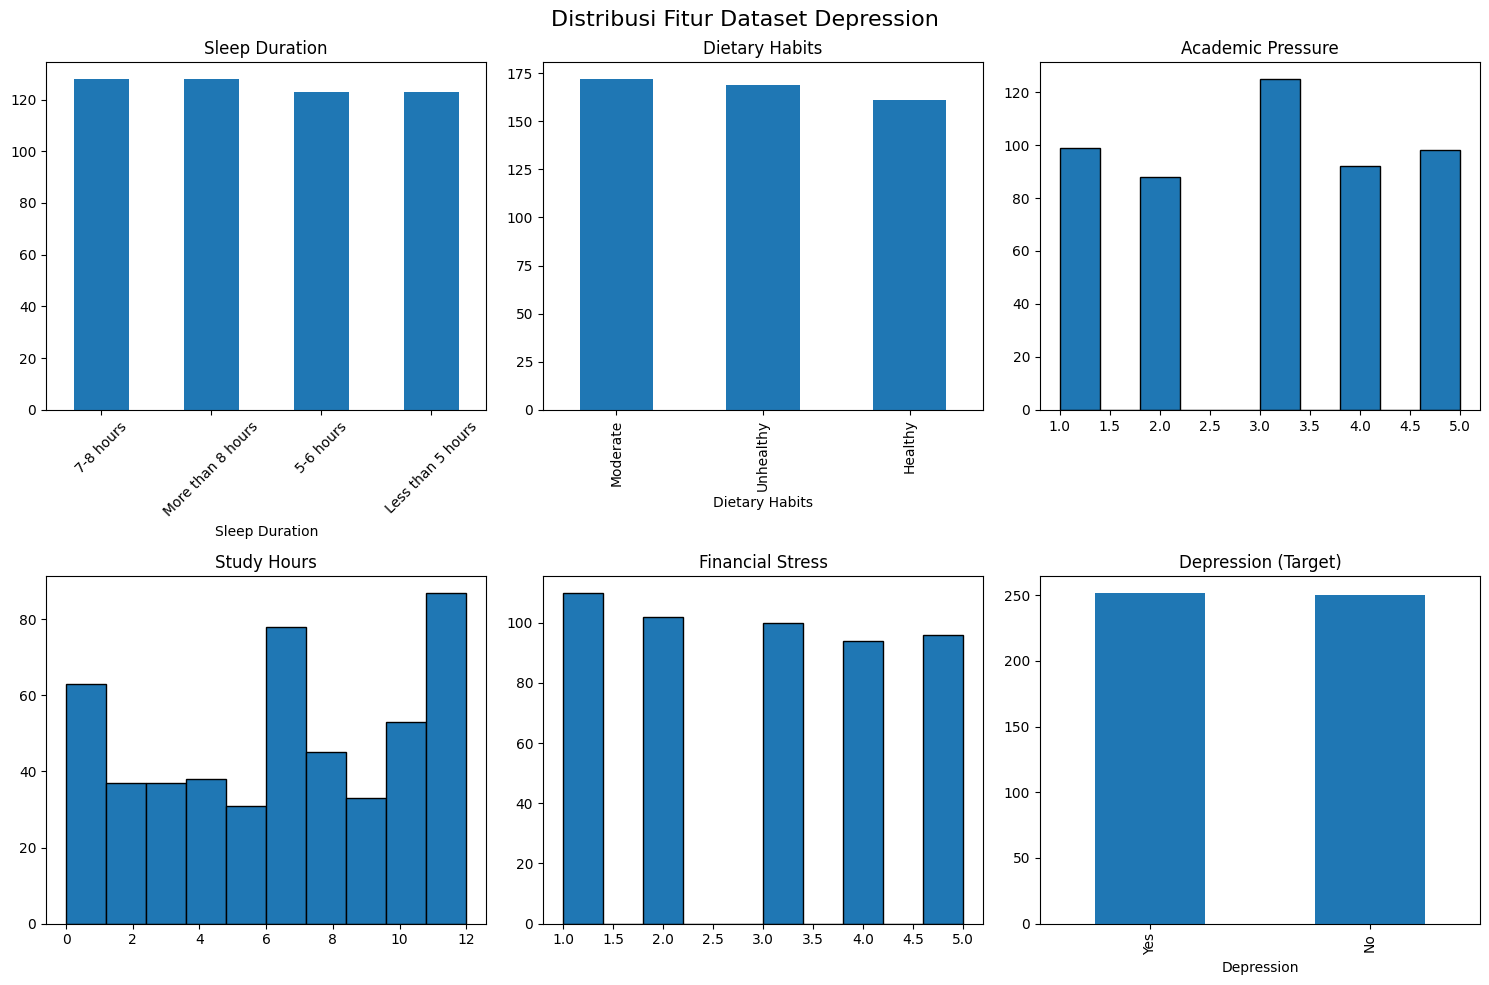


=== PREPROCESSING DATA ===
Preprocessing selesai!

Statistik Fitur Gabungan:
       Lifestyle_Score  Academic_Stress_Score  Depression_Predisposition
count       502.000000             502.000000                 502.000000
mean          1.898008               3.056308                   2.757968
std           0.530089               0.994328                   1.237652
min           0.800000               1.000000                   0.700000
25%           1.600000               2.333333                   2.100000
50%           2.000000               3.066667                   2.800000
75%           2.200000               3.800000                   3.600000
max           3.000000               5.000000                   5.000000

STEP 2: SETUP SISTEM FUZZY
----------------------------------------

Testing sistem dengan contoh data:
Hasil Mamdani: 0.500
Hasil Sugeno: 0.500

STEP 3: EVALUASI DAN PERBANDINGAN
----------------------------------------

PERBANDINGAN SISTEM FUZZY MAMDANI VS SUGEN

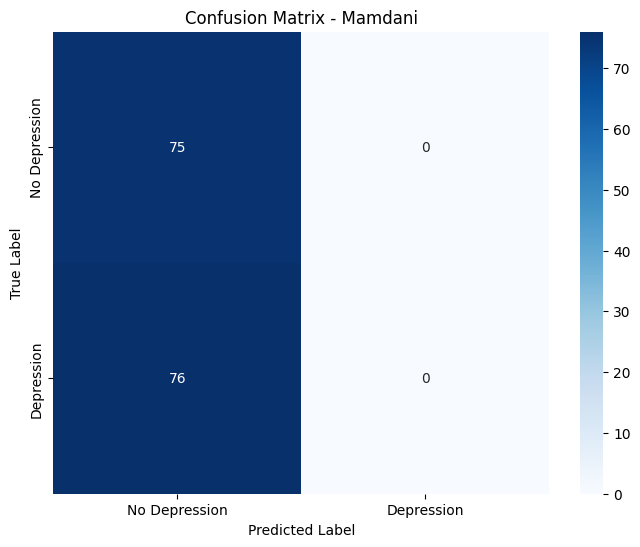


=== EVALUASI SISTEM SUGENO ===
Akurasi Sugeno: 0.4967 (49.67%)

Classification Report Sugeno:
               precision    recall  f1-score   support

No Depression       0.50      1.00      0.66        75
   Depression       0.00      0.00      0.00        76

     accuracy                           0.50       151
    macro avg       0.25      0.50      0.33       151
 weighted avg       0.25      0.50      0.33       151



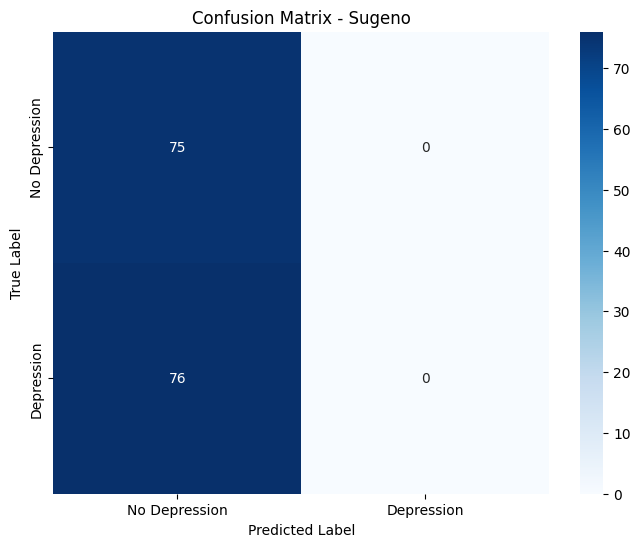


=== PERBANDINGAN HASIL ===
Akurasi Mamdani: 0.4967 (49.67%)
Akurasi Sugeno:  0.4967 (49.67%)
→ Kedua sistem memiliki akurasi yang sama


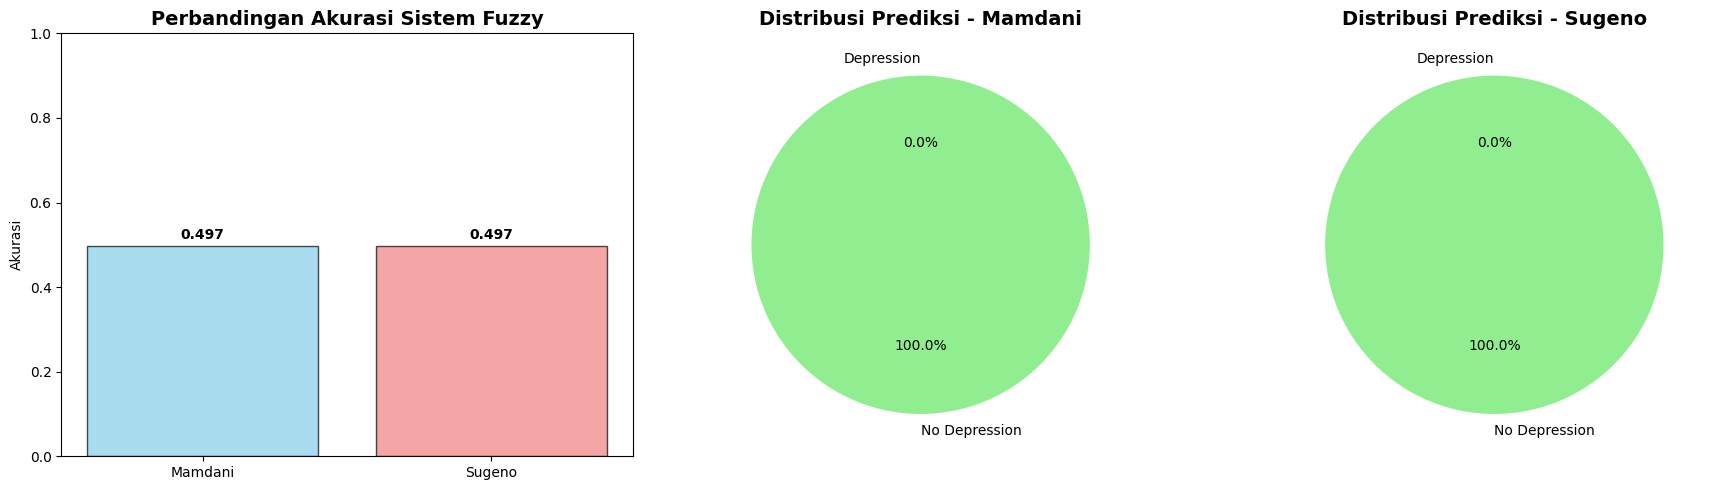


=== ANALISIS PENTINGNYA FITUR ===


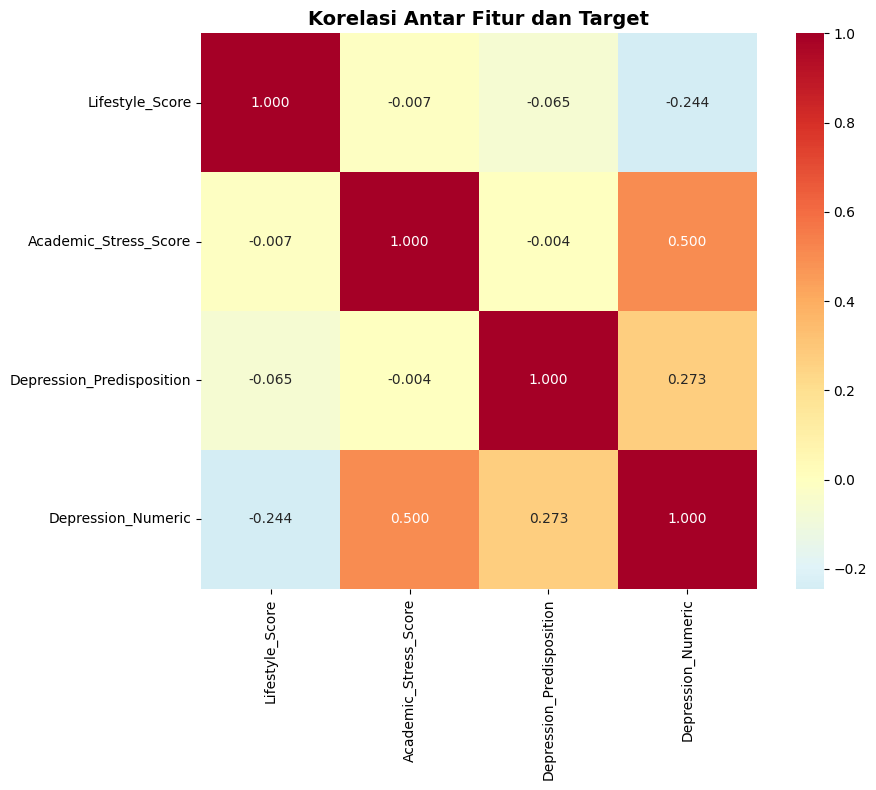

Korelasi fitur dengan Depression (diurutkan):
  Academic_Stress_Score: 0.500
  Depression_Predisposition: 0.273
  Lifestyle_Score: 0.244

KESIMPULAN
1. Akurasi Sistem Mamdani: 0.4967 (49.67%)
2. Akurasi Sistem Sugeno:  0.4967 (49.67%)
3. Kedua sistem memiliki performa yang sama

4. Rekomendasi:
   - Pilih berdasarkan kebutuhan: Mamdani untuk interpretabilitas,
     Sugeno untuk efisiensi


In [24]:
results = main()